# Setup

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import time
import datetime
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import json
import pickle
from scipy.signal import savgol_filter
import itertools


np.random.seed(42)

from formats import experiment_pb2
from formats import  quantification_pb2

from skimage import io
import pandas as pd
import utils
import gc

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset, ChainDataset


import os
import pyro
import pyro.distributions as dist
import pyro.poutine
from pyro.infer import MCMC, NUTS
import math
import torch.nn as nn
import torch.nn.functional as F
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.autoguide.guides import AutoDiagonalNormal
import pyro.distributions.constraints as constraints
from tqdm import trange

import utils



In [2]:
local_radius_px = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

In [3]:
import data
dataset = data.get_dataset(local_radius_px=local_radius_px)

In [5]:
from importlib import reload
import models
reload(models)
from models import FusionModel, SeparableVAE, JointVAE

In [7]:
import training
reload(training)
from training import train_model

In [8]:
pyro.clear_param_store()
torch.cuda.empty_cache()
gc.collect()
train_model(FusionModel, 
    {
        'latent_dim'    : 2,
        'n_classes'     : 1,
        'rgbu_dim'      : 16,
        'rgbu_samples'  : (2*local_radius_px)**2,
        'quant_dim'     : 52,
        'hidden_dim'    : 64,
        'hidden_depth'  : 16,
        'dropout'       : 0.0,
        'skip_connection': True,
        'device'        : device,
        'x_err_gamma'   : 0.1,
        'q_err_gamma'   : 0.325,
    },
    **{
        'num_epochs'    : 25,
        'learning_rate' : 2e-3,
        'batch_size'    : 64,
        'dataset'       : dataset,
        'device'        : device
    })

Epoch: 24  LR: 2.00E-10    Epoch Loss: 3.203E+06    Batch Loss: 4.968E+06  : 100%|██████████| 40250/40250 [1:27:02<00:00,  7.71it/s]


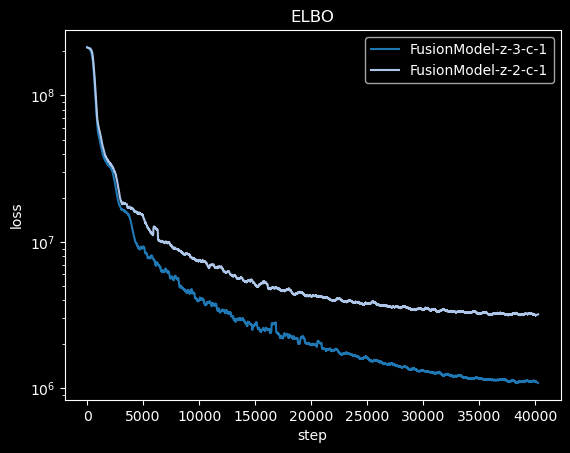

In [9]:

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

def add_loss_plot(z, c, m):

    dbfile = open(f'models/{m}-z-{z}-c-{c}-h-64-d-16-r-5-losses.pkl', 'rb')
    losses = pickle.load(dbfile)
    dbfile.close()

    plt.semilogy(savgol_filter(losses,2+(len(losses)//100),1),label=f'{m}-z-{z}-c-{c}')


add_loss_plot(z=3,c=1, m='FusionModel')
add_loss_plot(z=2,c=1, m='FusionModel')


plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.legend()
plt.show()